In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
from sklearn.metrics import mean_absolute_error

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Path to directories
path = '/content/drive/MyDrive/TFM - Neural ODEs/Neural ODE/df.csv'

# Read data
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path, sep=',', index_col='datetime', parse_dates=['datetime'], date_parser=date_parser)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-f9765ec2bc53>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


,demand,wind,price,day_of_week
datetime,,,,
2018-01-01 00:00:00,22718.1,11487.7,6.74,7
2018-01-01 01:00:00,21510.8,10123.2,4.74,7
2018-01-01 02:00:00,19865.8,8763.5,3.66,7
2018-01-01 03:00:00,19248.3,5661.2,2.30,7
2018-01-01 04:00:00,18632.1,5689.0,2.30,7


In [9]:
df = df[['wind']]
df

,wind
datetime,
2018-01-01 00:00:00,11487.700
2018-01-01 01:00:00,10123.200
2018-01-01 02:00:00,8763.500
2018-01-01 03:00:00,5661.200
2018-01-01 04:00:00,5689.000
...,...
2022-12-31 19:00:00,10060.700
2022-12-31 20:00:00,9969.200
2022-12-31 21:00:00,9.307


In [10]:
# Training set. From Tuesday to Tuesday: 14 months
train_df = df.loc['2018-01-01 00:00':'2019-12-31 23:00']
train_spot = train_df.values
train_df

,wind
datetime,
2018-01-01 00:00:00,11487.7
2018-01-01 01:00:00,10123.2
2018-01-01 02:00:00,8763.5
2018-01-01 03:00:00,5661.2
2018-01-01 04:00:00,5689.0
...,...
2019-12-31 19:00:00,1606.7
2019-12-31 20:00:00,1665.7
2019-12-31 21:00:00,1530.1


In [ ]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Preprocess data for Prophet
df.reset_index(level=0, inplace=True)
df.columns = ['ds', 'y']

# Normalize the data
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

In [ ]:
# Input window size selection by cross-validation

# Hyperparameters (window sizes) to test
windows = [30, 60, 90]

best_mae = float('inf')
best_window = None

residuals = []  # List to store residuals for all predictions

# Test different window sizes
for window in windows:
    maes = []  # List to store MAE of each iteration
    for i in range(window, len(df)-24):  # start after the initial window and go till 24 hrs before the end
        train = df.iloc[i-window:i]  # Train data is current point - window
        test = df.iloc[i:i+24]  # Test data is the next 24 hrs

        # Initialize and fit the model
        m = Prophet()
        m.fit(train)

        # Create future dataframe
        future = m.make_future_dataframe(periods=24, freq='H', include_history=False)

        # Make predictions
        forecast = m.predict(future)

        # Compute and append the MAE
        maes.append(mean_absolute_error(test['y'], forecast['yhat']))

        # Compute and store residuals for histogram
        residuals.extend((test['y'] - forecast['yhat']).values)

    # Compute and print the average MAE
    mae = pd.np.mean(maes)
    print(f'Window size {window}: MAE = {mae}')

    # Update the best MAE and best window size
    if mae < best_mae:
        best_mae = mae
        best_window = window

print(f'Best window size is {best_window} with average MAE {best_mae}')

# Plot the histogram of residuals
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

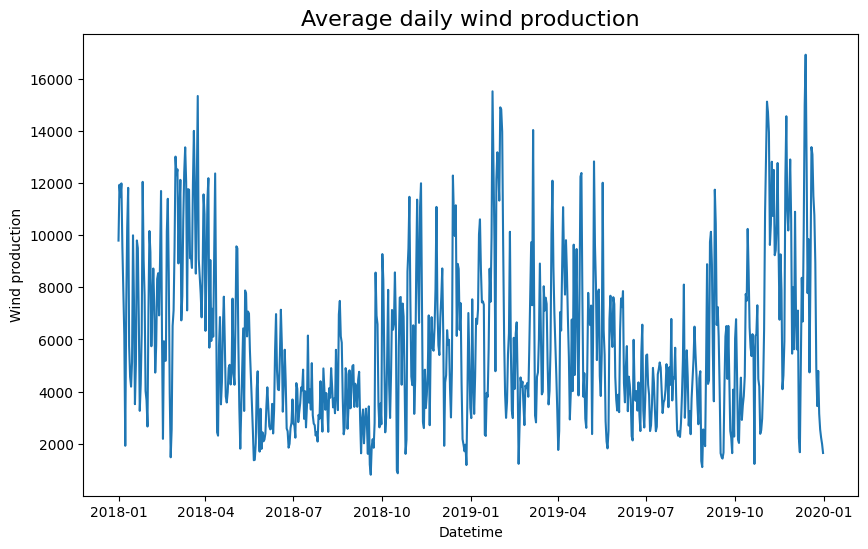

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

# Assuming 'wind' dataframe is your original data

# Resampling to daily frequency and calculating the mean
daily_wind = train_df.resample('D').mean()

# Creating a figure and an axis with custom size
fig, ax = plt.subplots(figsize=(10, 6))  # Width is 12 inches, Height is 6 inches

# Plotting the data
ax.plot(daily_wind.index, daily_wind['wind'])

# Adding title and labels
ax.set_title('Average daily wind production', fontsize=16)
ax.set_xlabel('Datetime')
ax.set_ylabel('Wind production')

# Save the figure before showing it
filename = 'average_daily_wind_production.png'
plt.savefig(filename, format='png', dpi=300)

# Download the file to your local system
files.download(filename)

# Showing the plot
plt.show()

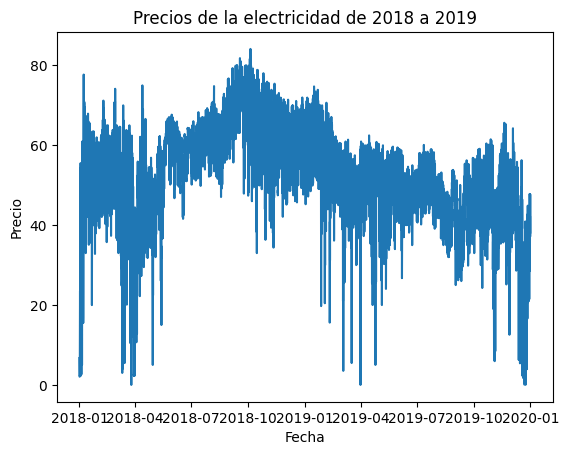

In [6]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar los datos
ax.plot(train_df.index, train_df['price'])

# Añadir título y etiquetas
ax.set_title('Average daily wind production')
ax.set_xlabel('Datetime')
ax.set_ylabel('Wind production')

# Mostrar la gráfica
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


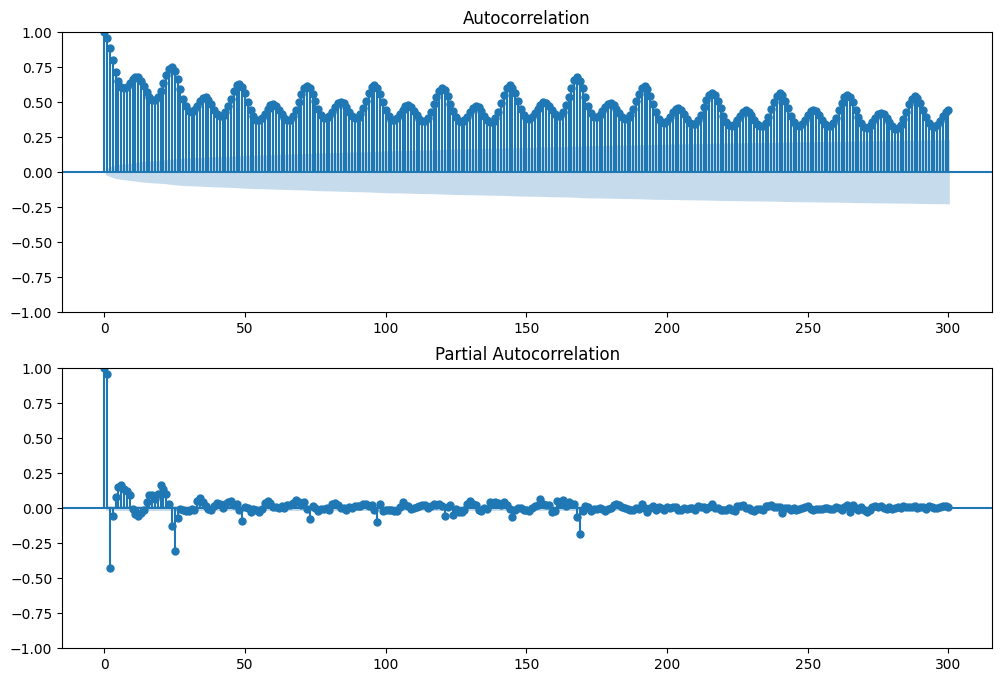

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time series: ACF and PACF
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# for 'price'
plot_acf(train_df, lags=300, ax=axs[0])
plot_pacf(train_df, lags=300, ax=axs[1])

plt.show()

In [ ]:
# Find the index of the maximum value in 'Electricity Price' column
max_index = train_df.idxmax()

# Print the index
print("Index with highest 'Electricity Price':", max_index)

Index with highest 'Electricity Price': price   2018-10-04 20:00:00
dtype: datetime64[ns]


In [ ]:
# Training days
days_year_defore = int(len(train_df)/24)
days_year_defore

421

In [ ]:
validation_df = df.loc['2019-06-07 00:00':'2019-08-30 23:00'] # 3 months Validation
validation_spot = validation_df.values
validation_df

,price
datetime,
2019-06-07 00:00:00,35.77
2019-06-07 01:00:00,31.08
2019-06-07 02:00:00,27.51
2019-06-07 03:00:00,26.73
2019-06-07 04:00:00,29.00
...,...
2019-08-30 19:00:00,52.34
2019-08-30 20:00:00,52.49
2019-08-30 21:00:00,51.51


In [ ]:
test_df = df.loc['2019-09-06 00:00':'2019-11-29 23:00'] # 3 months Test
test_spot = test_df.values
test_df

,price
datetime,
2019-09-06 00:00:00,31.75
2019-09-06 01:00:00,28.50
2019-09-06 02:00:00,27.90
2019-09-06 03:00:00,27.00
2019-09-06 04:00:00,26.21
...,...
2019-11-29 19:00:00,56.13
2019-11-29 20:00:00,53.05
2019-11-29 21:00:00,49.27


In [ ]:
# Test days
test_days = int(len(test_df)/24)
test_days

85

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Declaration of the scaler
scaler_price = MinMaxScaler(feature_range=(0, 1))

# The scaler is fitted with the training data
scaler_price.fit(train_df[["price"]])

# Apply scaler to the 'Electricity Price' column for each set
train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
test_df.loc[:, "price"] = scaler_price.transform(test_df[["price"]])

<ipython-input-17-b4dd611ea293>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
<ipython-input-17-b4dd611ea293>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
<ipython-input-17-b4dd611ea293>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
def create_windows(df, window_size=168, forecast_size=24):
    input_data, output_data = [], []

    # Step through the dataframe with a step size of 168 (7*24)
    for i in range(window_size, len(df) - forecast_size + 1, window_size):
        inputs = df.iloc[i-window_size:i]["price"].values
        outputs = df.iloc[i:i+forecast_size]["price"].values
        input_data.append(inputs)
        output_data.append(outputs)

    return np.array(input_data), np.array(output_data)

window_size = 168
forecast_size = 24

X_train, Y_train = create_windows(train_df, window_size, forecast_size)
X_validation, Y_validation = create_windows(validation_df, window_size, forecast_size)
X_test, Y_test = create_windows(test_df, window_size, forecast_size)

In [ ]:
X_train.shape

(60, 168)

In [ ]:
Y_train.shape

(60, 24)

In [ ]:
Y_train[1]

array([0.44134078, 0.4327826 , 0.42565078, 0.41733032, 0.41602282,
       0.4197076 , 0.50255557, 0.56448354, 0.59396173, 0.57874718,
       0.51598716, 0.5014858 , 0.48401284, 0.45263283, 0.42208487,
       0.41233805, 0.40591941, 0.43634851, 0.47557352, 0.4958992 ,
       0.53120171, 0.5489124 , 0.51931535, 0.49934625])

In [ ]:
X_validation.shape

(12, 168)

In [ ]:
X_test.shape

(12, 168)

In [ ]:
# Convert your data to PyTorch tensors and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float().to(device)
Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float().to(device)
X_train_tensor = torch.tensor(X_train).float().to(device)  # Reshape to (batch_size, sequence_length, number_of_features)
Y_train_tensor = torch.tensor(Y_train).float().to(device)
X_val_tensor = torch.tensor(X_validation).unsqueeze(-1).float().to(device)
Y_val_tensor = torch.tensor(Y_validation).unsqueeze(-1).float().to(device)
X_val_tensor = torch.tensor(X_validation).float().to(device)  # Reshape to (batch_size, sequence_length, number_of_features)
Y_val_tensor = torch.tensor(Y_validation).float().to(device)

In [ ]:
X_train_tensor.shape

torch.Size([60, 168])

In [ ]:
Y_train_tensor.shape

torch.Size([60, 24])

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layer_neurons, output_size):
        super(MLPModel, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, output_size),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [ ]:
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# Learning Rate Scheduler
LR_INICIO = 10  # initial learning rate
LR_FINAL = 1e-10  # final learning rate
LR_EPOCHS = 100  # total number of epochs

# Convert your data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)

model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=700, output_size=24)

# initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=LR_INICIO, momentum=0.9)

# set the learning rate scheduler
lr_lambda = lambda epoch: LR_FINAL / LR_INICIO * (LR_INICIO / LR_FINAL)**(1 - epoch / LR_EPOCHS)
scheduler = LambdaLR(optimizer, lr_lambda)

# define your loss function
loss_fn = nn.L1Loss()

# training loop
for epoch in range(LR_EPOCHS):
    # forward pass
    output = model(X_train_tensor)
    loss = loss_fn(output, Y_train_tensor)

    # backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # learning rate scheduling
    scheduler.step()

    print(f"Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]}")

Epoch 1, Learning Rate: 7.762471166286916
Epoch 2, Learning Rate: 6.025595860743575
Epoch 3, Learning Rate: 4.677351412871979
Epoch 4, Learning Rate: 3.630780547701011
Epoch 5, Learning Rate: 2.818382931264451
Epoch 6, Learning Rate: 2.18776162394955
Epoch 7, Learning Rate: 1.6982436524617417
Epoch 8, Learning Rate: 1.3182567385564088
Epoch 9, Learning Rate: 1.023292992280755
Epoch 10, Learning Rate: 0.794328234724282
Epoch 11, Learning Rate: 0.6165950018614824
Epoch 12, Learning Rate: 0.4786300923226384
Epoch 13, Learning Rate: 0.3715352290971725
Epoch 14, Learning Rate: 0.28840315031266056
Epoch 15, Learning Rate: 0.22387211385683387
Epoch 16, Learning Rate: 0.17378008287493746
Epoch 17, Learning Rate: 0.13489628825916522
Epoch 18, Learning Rate: 0.10471285480509013
Epoch 19, Learning Rate: 0.08128305161641003
Epoch 20, Learning Rate: 0.06309573444801941
Epoch 21, Learning Rate: 0.04897788193684467
Epoch 22, Learning Rate: 0.038018939632056145
Epoch 23, Learning Rate: 0.0295120922666

In [ ]:
# Define the learning rate array
lrs = LR_INICIO * (LR_FINAL / LR_INICIO) ** (np.arange(LR_EPOCHS) / LR_EPOCHS)
lrs

array([1.00000000e+01, 7.76247117e+00, 6.02559586e+00, 4.67735141e+00,
       3.63078055e+00, 2.81838293e+00, 2.18776162e+00, 1.69824365e+00,
       1.31825674e+00, 1.02329299e+00, 7.94328235e-01, 6.16595002e-01,
       4.78630092e-01, 3.71535229e-01, 2.88403150e-01, 2.23872114e-01,
       1.73780083e-01, 1.34896288e-01, 1.04712855e-01, 8.12830516e-02,
       6.30957344e-02, 4.89778819e-02, 3.80189396e-02, 2.95120923e-02,
       2.29086765e-02, 1.77827941e-02, 1.38038426e-02, 1.07151931e-02,
       8.31763771e-03, 6.45654229e-03, 5.01187234e-03, 3.89045145e-03,
       3.01995172e-03, 2.34422882e-03, 1.81970086e-03, 1.41253754e-03,
       1.09647820e-03, 8.51138038e-04, 6.60693448e-04, 5.12861384e-04,
       3.98107171e-04, 3.09029543e-04, 2.39883292e-04, 1.86208714e-04,
       1.44543977e-04, 1.12201845e-04, 8.70963590e-05, 6.76082975e-05,
       5.24807460e-05, 4.07380278e-05, 3.16227766e-05, 2.45470892e-05,
       1.90546072e-05, 1.47910839e-05, 1.14815362e-05, 8.91250938e-06,
      

LR: 10.0
Loss: 11.279991149902344
LR: 7.762471166286917
Loss: 40.219261169433594
LR: 6.025595860743578
Loss: 4.065287113189697
LR: 4.677351412871983
Loss: 2.741691827774048
LR: 3.6307805477010135
Loss: 2.7932395935058594
LR: 2.8183829312644537
Loss: 2.5923051834106445
LR: 2.1877616239495525
Loss: 2.1060307025909424
LR: 1.6982436524617441
Loss: 1.8353649377822876
LR: 1.318256738556407
Loss: 1.3469675779342651
LR: 1.023292992280754
Loss: 1.0466253757476807
LR: 0.7943282347242814
Loss: 0.7127445936203003
LR: 0.6165950018614821
Loss: 0.5485191345214844
LR: 0.47863009232263837
Loss: 0.3239515423774719
LR: 0.37153522909717246
Loss: 0.2528623938560486
LR: 0.2884031503126605
Loss: 0.1555986851453781
LR: 0.22387211385683398
Loss: 0.14484019577503204
LR: 0.17378008287493754
Loss: 0.11302082985639572
LR: 0.1348962882591653
Loss: 0.09585735201835632
LR: 0.10471285480508997
Loss: 0.08827522397041321
LR: 0.08128305161640993
Loss: 0.08478324115276337
LR: 0.06309573444801932
Loss: 0.08221029490232468


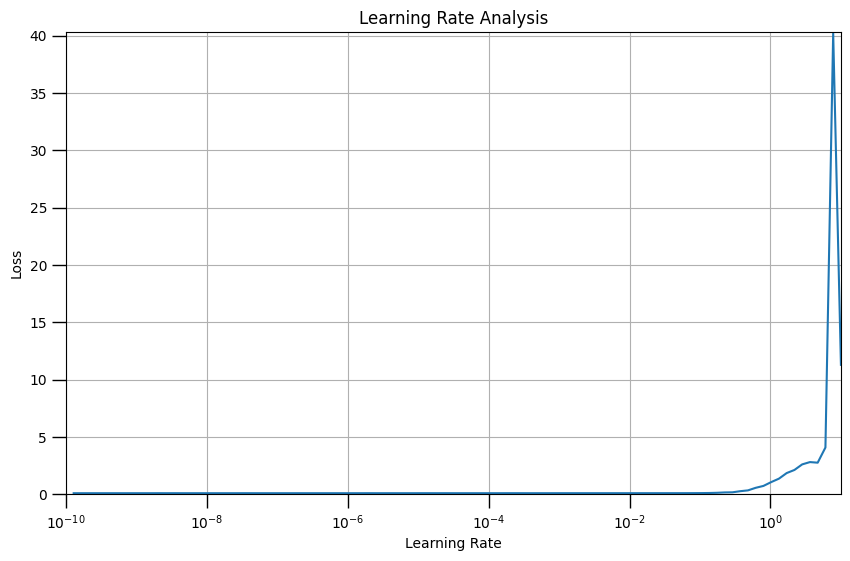

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the learning rate array
lrs = LR_INICIO * (LR_FINAL / LR_INICIO) ** (np.arange(LR_EPOCHS) / LR_EPOCHS)

# Define an array to store the loss values
loss_values = []

# Training loop
for LR in lrs:
    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    for epoch in range(LR_EPOCHS):
        # Forward pass and backward pass
        output = model(X_train_tensor)
        loss = loss_fn(output, Y_train_tensor)
        loss.backward()

        # Optimization step
        optimizer.step()
        optimizer.zero_grad()

    # Store the loss value
    loss_values.append(loss.item())
    print('LR:', LR)
    print('Loss:', loss.item())

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

loss_values = np.array(loss_values)

# Plot the loss in log scale
plt.semilogx(lrs, loss_values)

# Increase the tickmarks size
plt.tick_params(axis='both', length=10, width=1)

# Set the plot boundaries
plt.axis([LR_FINAL, LR_INICIO, 0, max(loss_values)+0.1])

# Set the labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Analysis')

# Show the plot
plt.show()

In [ ]:
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=100, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt') # <-- saves model to disk
        self.val_loss_min = val_loss

In [ ]:
# Create a model
model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=500, output_size=24).to(device)

# Loss criterion
criterion = nn.L1Loss()

# Optimizer
LR = 0.005
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

# To track loss history
loss_history = []
val_loss_history = []

# Initialize the EarlyStopping class
early_stopping = EarlyStopping(patience=300, verbose=True)

for epoch in range(2000):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, Y_val_tensor)

    print('Epoch [%d], Loss: %.4f, Val Loss: %.4f' % (epoch+1, loss.item(), val_loss.item()))

    loss_history.append(loss.item())
    val_loss_history.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch [1], Loss: 0.6703, Val Loss: 0.5779
Validation loss decreased (inf --> 0.577925).  Saving model ...
Epoch [2], Loss: 0.6987, Val Loss: 0.5769
Validation loss decreased (0.577925 --> 0.576930).  Saving model ...
Epoch [3], Loss: 0.6977, Val Loss: 0.5756
Validation loss decreased (0.576930 --> 0.575617).  Saving model ...
Epoch [4], Loss: 0.6963, Val Loss: 0.5740
Validation loss decreased (0.575617 --> 0.574018).  Saving model ...
Epoch [5], Loss: 0.6946, Val Loss: 0.5722
Validation loss decreased (0.574018 --> 0.572160).  Saving model ...
Epoch [6], Loss: 0.6926, Val Loss: 0.5701
Validation loss decreased (0.572160 --> 0.570068).  Saving model ...
Epoch [7], Loss: 0.6904, Val Loss: 0.5678
Validation loss decreased (0.570068 --> 0.567766).  Saving model ...
Epoch [8], Loss: 0.6879, Val Loss: 0.5653
Validation loss decreased (0.567766 --> 0.565273).  Saving model ...
Epoch [9], Loss: 0.6852, Val Loss: 0.5626
Validation loss decreased (0.565273 --> 0.562600).  Saving model ...
Epoch 

<All keys matched successfully>

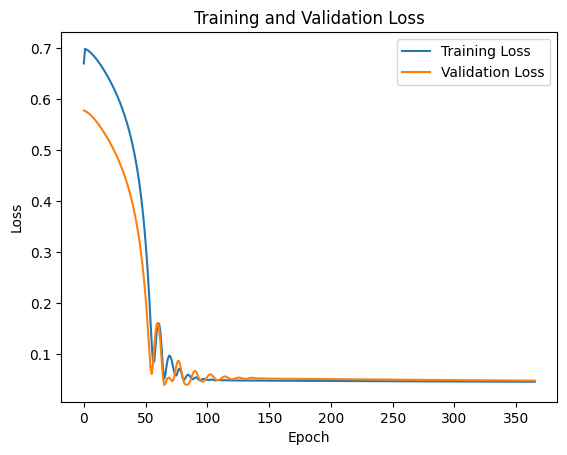

In [ ]:
# Plot the loss history
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Create a model
model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=500, output_size=24)

# Load the saved weights
model.load_state_dict(torch.load('checkpoint.pt'))

# Move the model to the appropriate device
model = model.to(device)

# Convert the test data to a PyTorch tensor and move it to the appropriate device
X_test_tensor = torch.tensor(X_test).float().to(device)

# Set the model to evaluation mode
model.eval()

# Generate predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor)

In [ ]:
# Convert the predictions to a numpy array and move them back to the CPU
test_predictions_np = test_predictions.cpu().numpy()

# Initialize an empty array to hold the inverse-transformed predictions
predictions = np.empty_like(test_predictions_np)

# Inverse-transform each prediction separately
for i in range(test_predictions_np.shape[1]):
    predictions[:, i] = scaler_price.inverse_transform(test_predictions_np[:, i:i+1]).flatten()

# Now `predictions` should contain the inverse-transformed predictions

In [ ]:
Y_test_np = Y_test  # Replace with your actual Y_test

# Initialize an empty array to hold the inverse-transformed labels
y_test = np.empty_like(Y_test_np)

# Inverse-transform each label separately
for i in range(Y_test_np.shape[1]):
    y_test[:, i] = scaler_price.inverse_transform(Y_test_np[:, i:i+1]).flatten()

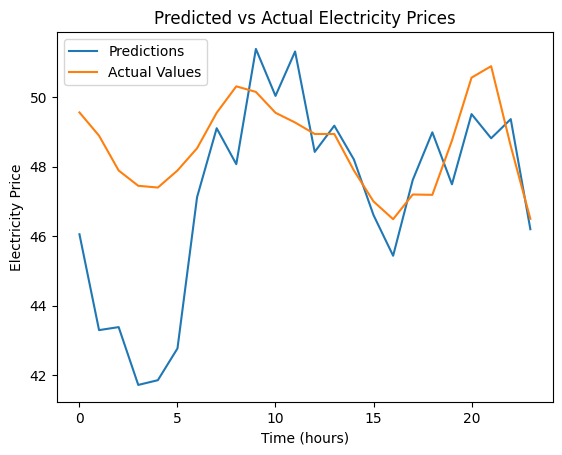

In [ ]:
# Create a figure and axes for the plot
fig, ax = plt.subplots()

# Plot the predictions and actual values
ax.plot(predictions[2], label='Predictions')
ax.plot(y_test[2], label='Actual Values')

# Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Electricity Price')
ax.set_title('Predicted vs Actual Electricity Prices')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  51.14200239551966
MAE:  4.993779445224338


In [ ]:
# Histogram of residuals
def residual_histogram(y_true, y_pred, step):
    # copy of the input lists
    true = y_true[:]
    pred = y_pred[:]
    # empty list to allocate residuals
    residual = []
    if len(true) ==len(pred):
        for cicle in range(len(true)):
            for item in range(len(true[cicle])):
                residual.append(true[cicle][item] - pred[cicle][item])

    minim = min(residual)
    maxim = max(residual)

    bins = int(abs((maxim - minim) / step))

    df = pd.DataFrame(residual)
    hist = df.hist(bins = bins)
    return residual

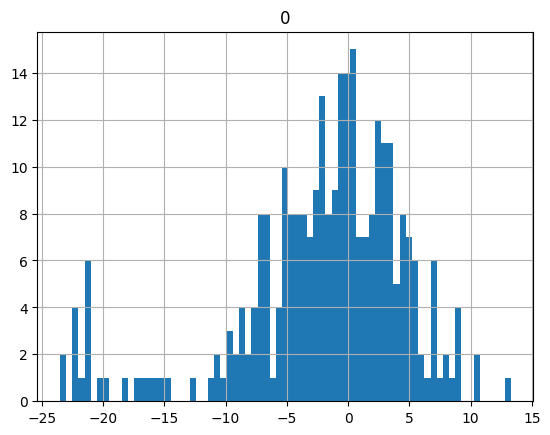

In [ ]:
residuals = residual_histogram(y_test, predictions, 0.5)